# VQLS for Pendulum (Non-Linear)

In [46]:
import numpy as np
import matplotlib.pyplot as plt

#Create matrix A
n1 = 4
w = 1
h = 0.01 #Step Size

A1 = np.zeros((n1,n1))
for i in range(n1):
    A1[i,i] = 1
A1[2,0] = -1
A1[2,1] = - h
A1[3,1] = -1

print("A_matrix:",A1)

A1_dag = A1.conj().T

print("A^dagger:",A1_dag)

n= 2*n1
Amat = np.zeros((n,n))
for i in range(n1):
    for j in range(n1,n):
        Amat[i,j] = A1[i,j-n1]

for i in range(n1,n):
    for j in range(n1):
        Amat[i,j] = A1_dag[i-n1,j]

print("A_final:", Amat)

print("Condition number of Amat:", np.linalg.cond(Amat))


A_matrix: [[ 1.    0.    0.    0.  ]
 [ 0.    1.    0.    0.  ]
 [-1.   -0.01  1.    0.  ]
 [ 0.   -1.    0.    1.  ]]
A^dagger: [[ 1.    0.   -1.    0.  ]
 [ 0.    1.   -0.01 -1.  ]
 [ 0.    0.    1.    0.  ]
 [ 0.    0.    0.    1.  ]]
A_final: [[ 0.    0.    0.    0.    1.    0.    0.    0.  ]
 [ 0.    0.    0.    0.    0.    1.    0.    0.  ]
 [ 0.    0.    0.    0.   -1.   -0.01  1.    0.  ]
 [ 0.    0.    0.    0.    0.   -1.    0.    1.  ]
 [ 1.    0.   -1.    0.    0.    0.    0.    0.  ]
 [ 0.    1.   -0.01 -1.    0.    0.    0.    0.  ]
 [ 0.    0.    1.    0.    0.    0.    0.    0.  ]
 [ 0.    0.    0.    1.    0.    0.    0.    0.  ]]
Condition number of Amat: 2.629791900005034


## One step VQLS

Is Hermitian? True
Imag part of coeffs: 0.25


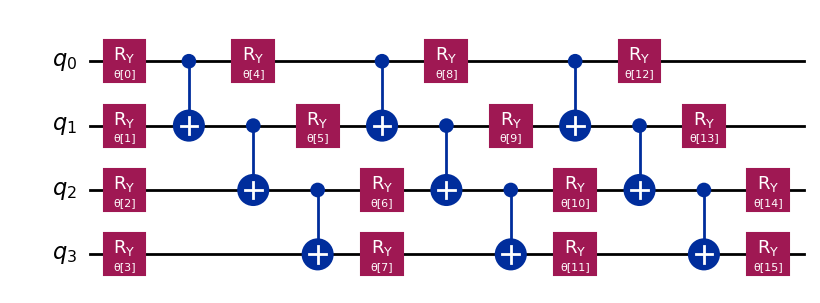

Optimal Parameters: [ 1.567127    1.56547941  0.65912618  4.71191233  4.72583939  5.93221421
  5.61015607  3.14104927 -0.00892286  4.46617636  4.80990957  3.14260061
  6.27893679  3.67194584  0.36387747  4.71103728]
Minimum Cost: 1.1729450679428336e-07


In [4]:
from qiskit import QuantumCircuit,transpile
from qiskit.quantum_info import SparsePauliOp,DensityMatrix
from qiskit.circuit.library import TwoLocal,n_local
from qiskit_aer import AerSimulator
from qiskit_aer.primitives import EstimatorV2
from qiskit.quantum_info import Operator
from scipy.optimize import minimize
import numpy as np

estimator = EstimatorV2()

I4 = SparsePauliOp.from_list([("IIII", 1.0)])

#Step 1: Operator A
#A_mat = np.array([[4,1,0,0],[1,3,1,0],[0,1,2,1],[0,0,1,1]])
A_op = SparsePauliOp.from_operator(Amat)

#Step 2: |b> vector normalized, encoding in circuit and creating a density matrix |b><b|
bvec = [1,0,0,0,np.sin(1),0,0,0]
Bvec1 = np.zeros(n)
for i in range(n1):
    Bvec1[i] = bvec[i]
norm1 = np.linalg.norm(Bvec1)
B_vec = Bvec1 / norm1
B_mat = DensityMatrix(B_vec)
B_op = SparsePauliOp.from_operator(B_mat)

#step 3: Cost Hamiltonian
Ham = A_op @ (I4 - B_op) @ A_op

#checking H is hermitian
print("Is Hermitian?", np.allclose(Ham.to_matrix(), Ham.to_matrix().conj().T))

#Checking any imaginary coefficients
print("Imag part of coeffs:", np.imag(Ham.coeffs).max())

#Display the Hamiltonian as matrix
#print("Cost_Hamiltonian:",Ham.to_matrix())

# Make the operator Hermitian (just in case)
Ham = 0.5 * (Ham + Ham.adjoint())

# Strip all imaginary parts: only real part is needed
Ham = SparsePauliOp(Ham.paulis, coeffs=np.real(Ham.coeffs))

#Step 4: Create ansatz (four-local circuit)

ansatz = n_local(4, rotation_blocks="ry", entanglement_blocks="cx", entanglement="linear", reps=3)
display(ansatz.draw("mpl"))

#Step 5: evaluate cost function
def costfunc(params):
    #state = ansatz.bind_parameters(params)
    job = estimator.run([(ansatz,Ham,params)])
    result = job.result()
    value  = result[0].data.evs
    return value

#step 6: optimization
initial_params = np.random.uniform(0, 2*np.pi, size=ansatz.num_parameters)
result = minimize(costfunc, initial_params, method='COBYLA',options={'maxiter': 500,'tol': 1e-10})
print("Optimal Parameters:", result.x)
print("Minimum Cost:", result.fun)


In [5]:
# To create the statevector from above optimal values
from qiskit.quantum_info import Statevector

# Create circuit with optimal parameters
optimal_params = result.x
optimal_circuit = ansatz.assign_parameters(optimal_params)

# Get statevector from the circuit
statevector = Statevector.from_instruction(optimal_circuit)

# Show vector (solution |x⟩)
print("Approximate solution |x⟩:", statevector.data)
print("final sol:", statevector[8])
display(statevector.draw("latex"))


Approximate solution |x⟩: [-2.20946973e-04+0.j  1.43080546e-07+0.j  1.89337567e-06+0.j
  1.08231961e-06+0.j -1.96582778e-04+0.j  4.88500228e-07+0.j
  1.27913572e-04+0.j -1.25162895e-06+0.j -6.07662083e-01+0.j
 -2.79789567e-05+0.j -6.07655092e-01+0.j  5.14967318e-03+0.j
 -5.11346702e-01+0.j  8.29343971e-05+0.j -1.05087653e-06+0.j
 -2.50810844e-05+0.j]
final sol: (-0.6076620834881974+0j)


<IPython.core.display.Latex object>

In [30]:
#Classsical Solution
# Original A matrix
Acl = Amat

# Original b vector
bvec = [1,0,0,0,np.sin(1),0,0,0]
Bvec1 = np.zeros(n)
for i in range(n1):
    Bvec1[i] = bvec[i]
bcl = Bvec1
#bcl = bcl / np.linalg.norm(bcl)

# Classical solution
x_classical = np.linalg.solve(Acl, bcl)
#x_classical = x_classical / np.linalg.norm(x_classical)  # normalized for comparison
print("Classical solution:", x_classical)
norm_cl = np.linalg.norm(x_classical)
print("norm:",norm_cl)


Classical solution: [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  1.00000000e+00  0.00000000e+00  1.00000000e+00 -8.41470985e-04
  8.41470985e-01  0.00000000e+00  0.00000000e+00  0.00000000e+00]
norm: 1.645622716890779


## VQLS for all steps

In [47]:
#Creating Loop with VQLS code in it
from qiskit import QuantumCircuit,transpile
from qiskit.quantum_info import SparsePauliOp,DensityMatrix,Statevector
from qiskit.circuit.library import n_local
from qiskit_aer import AerSimulator
from qiskit_aer.primitives import EstimatorV2
from qiskit.quantum_info import Operator
from scipy.optimize import minimize
import numpy as np

estimator = EstimatorV2()

I3 = SparsePauliOp.from_list([("III", 1.0)])

# Defining Operator A and vector B
A_op = SparsePauliOp.from_operator(Amat)
bvec = [1,0,0,-h*w*w*np.sin(1)]
Bvec1 = np.zeros(n)
for i in range(n1):
    Bvec1[i] = bvec[i]

#Define the cost function
def costfunc(params):
    job = estimator.run([(ansatz,Ham,params)])
    result = job.result()
    value  = result[0].data.evs
    return value

#Step: Create ansatz (two-local circuit)
ansatz = n_local(3, rotation_blocks=["ry"], entanglement_blocks="cx", entanglement="circular", reps=3)


#Creating a VQLS loop
nf = 1000 #iterations
x_fin = np.zeros(nf)
y_fin = np.zeros(nf)
x_fin[0] = bvec[0] 
y_fin[0] = bvec[1]

np.random.seed(0)

for i in range(1,nf):  
    #Operator from b (|b><b|)
    norm1 = np.linalg.norm(Bvec1)
    B_vec = Bvec1 / norm1
    B_mat = DensityMatrix(B_vec)
    B_op = SparsePauliOp.from_operator(B_mat)
    
    #Cost Hamiltonian
    Ham = A_op @ (I3 - B_op) @ A_op

    #checking H is hermitian
    #print("Is Hermitian?", np.allclose(Ham.to_matrix(), Ham.to_matrix().conj().T))

    #Checking any imaginary coefficients
    #print("Imag part of coeffs:", np.imag(Ham.coeffs).max())

    # Make the operator Hermitian (just in case)
    Ham = 0.5 * (Ham + Ham.adjoint())

    # Strip all imaginary parts: only real part is needed
    Ham = SparsePauliOp(Ham.paulis, coeffs=np.real(Ham.coeffs))
    
    #step 6: optimization
    
    if i == 1:
        initial_params = np.zeros(ansatz.num_parameters)
    else:
        initial_params = optimal_params

    #initial_params = np.random.uniform(0, 2*np.pi, size=ansatz.num_parameters)
    result = minimize(costfunc, initial_params, method='COBYLA',options={'maxiter': 500,'tol': 1e-10})
    optimal_params = result.x
    optimal_circuit = ansatz.assign_parameters(optimal_params)
    statevector = Statevector.from_instruction(optimal_circuit)
    y_quantum = statevector.data
    #print("Minimum Cost:", result.fun)

    #Classical solution of matrix
    xhat = y_quantum
    Axhat = Amat @ xhat
    x_norm = np.linalg.norm(Bvec1)/np.linalg.norm(Axhat)
    c = np.vdot(Bvec1, Axhat) / np.vdot(Axhat, Axhat)
    #x_q = c * xhat
    x_q = x_norm * xhat
    
    #Array of solution
    x_qm = np.zeros(n)
    for k in range(n):
        x_qm[k] = x_q[k].real

    v = x_qm[4:8]  # second half
    xi, yi, xip1, yip1 = v

    #print("Euler residuals:",xip1 - (xi + h*yi),yip1 - (yi - h*w*w*np.sin(xi)))
    #print("sin consistency:", sinxi - np.sin(xi))


    #update B vector
    Bvec1[0] = x_qm[6]
    Bvec1[1] = x_qm[7]
    Bvec1[3] = -h*w*w*np.sin(x_qm[6])
    #print("updated Bvec:",Bvec1)
    #print(f"Sol at {i} step:{y_qm}")
    
    #Final solution
    x_fin[i] = x_qm[6]
    y_fin[i] = x_qm[7]
    #print(y_fin[i])

print("Quantum x solution:", x_fin)
print("Quantum y solution:", y_fin)



Quantum x solution: [ 1.          0.99998887  0.99990564  0.99973786  0.99948618  0.99914944
  0.99872876  0.99822446  0.99763623  0.99696386  0.99620752  0.99536716
  0.99444293  0.99343476  0.99234284  0.99116682  0.98990704  0.98856412
  0.98713728  0.985627    0.98403353  0.98235625  0.9805959   0.97875234
  0.9768257   0.97481596  0.97272321  0.97054792  0.96829     0.96594974
  0.96352698  0.96102194  0.95843473  0.95576546  0.9530145   0.95018181
  0.94726753  0.94427196  0.9411952   0.93803733  0.93479875  0.93147953
  0.92807985  0.92459994  0.92104002  0.91740022  0.91368076  0.90988193
  0.90600392  0.90204699  0.89801127  0.89389712  0.88970477  0.88543449
  0.88108653  0.87666115  0.8721586   0.86757922  0.86292327  0.85819103
  0.85338285  0.84849897  0.84353975  0.83850548  0.83339653  0.82821322
  0.82295587  0.81762488  0.81222057  0.80674327  0.8011934   0.79557134
  0.78987745  0.78411214  0.7782758   0.77236885  0.76639168  0.76034473
  0.75422842  0.74804322  0.741

In [26]:
np.sin(1)

0.8414709848078965

Comparison between Classical and Quantum

In [50]:
import numpy as np

#h = 0.01
omega = 1.0
nf = len(x_fin)
t = np.arange(nf)*h
#x_exact = np.cos(omega*t)

# explicit Euler for comparison
x_e = np.zeros(nf); y_e = np.zeros(nf)
x_e_l = np.zeros(nf); y_e_l = np.zeros(nf)
x_e[0]=1.0; y_e[0]=0.0
x_e_l[0]=1.0; y_e_l[0]=0.0
for i in range(nf-1):
    x_e[i+1] = x_e[i] + h*y_e[i]
    y_e[i+1] = y_e[i] - h*(omega**2)*np.sin(x_e[i])
    x_e_l[i+1] = x_e_l[i] + h*y_e_l[i]
    y_e_l[i+1] = y_e_l[i] - h*(omega**2)*x_e_l[i]

#print("x_exact:", x_exact)
print("x_euler:", x_e)
print("x_euler_linear",x_e_l)
print("x_vqls :", x_fin)
print("residual",x_e-x_fin)


x_euler: [ 1.          1.          0.99991585  0.99974756  0.99949512  0.99915855
  0.99873786  0.99823307  0.9976442   0.99697128  0.99621434  0.99537341
  0.99444854  0.99343978  0.99234717  0.99117077  0.98991064  0.98856685
  0.98713945  0.98562853  0.98403417  0.98235644  0.98059544  0.97875126
  0.976824    0.97481375  0.97272064  0.97054476  0.96828624  0.96594521
  0.96352178  0.96101609  0.95842828  0.9557585   0.95300688  0.95017359
  0.94725879  0.94426263  0.94118529  0.93802694  0.93478777  0.93146796
  0.9280677   0.9245872   0.92102664  0.91738625  0.91366624  0.90986682
  0.90598823  0.9020307   0.89799446  0.89387977  0.88968687  0.88541602
  0.88106747  0.87664152  0.87213842  0.86755846  0.86290193  0.85816912
  0.85336034  0.8484759   0.84351611  0.83848129  0.83337177  0.82818789
  0.82292998  0.81759841  0.81219352  0.80671569  0.80116527  0.79554265
  0.78984822  0.78408236  0.77824547  0.77233797  0.76636026  0.76031278
  0.75419594  0.74801019  0.74175596  0.73

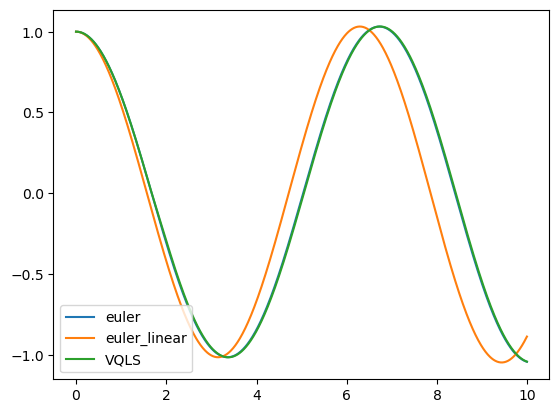

In [51]:
import matplotlib.pyplot as plt

#plt.plot(t,x_exact,label='exact')
plt.plot(t,x_e,label='euler')
plt.plot(t,x_e_l,label='euler_linear')
plt.plot(t,x_fin,label='VQLS')


plt.legend()
plt.show()